In [1]:
""" Python Standard Library """
import os
import datetime as dt

import json
import logging
""" Third Party Imports """
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
""" Local Imports """
if 'requirements.txt' not in os.listdir(os.getcwd()):
    os.chdir(os.path.join('..','..','..'))
print(os.getcwd())
from covid_model.rmw_model import RMWCovidModel
from covid_model.runnable_functions import do_single_fit, do_create_report
from covid_model.utils import setup, get_filepath_prefix
from covid_model.analysis.charts import plot_transmission_control

os.environ['gcp_project'] = 'co-covid-models'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "co-covid-models-credentials.json"

outdir = setup("variant_share_qc.ipynb")

/Users/brittneycontreras/PycharmProjects/covid-rmw-model


2023/02/08 14:26:30 INFO|============================================================


In [2]:
import pandas as pd
obs_fpath = "covid_model/model_dev_qc/variants/CDPHE Variant Data (manually transcribed and limited to model variants).csv"
obs = pd.read_csv(obs_fpath, parse_dates=['Date']).fillna(0)
obs['Date'] = [d.date() for d in obs['Date']]
obs = obs.set_index('Date')

In [3]:
seeds = [
    {"param": "wildtype_seed", "attrs": None, "vals": { "2020-01-01": 0,"2020-01-24": 1.9,"2020-01-30": 0}, "desc": "2.2 wildtype seeds are planted each day in CO starting January 24th, 2020"},
    {"param": "alpha_seed", "attrs": None, "vals": {"2020-01-01": 0,"2020-11-09": 0.87,"2020-12-04": 0}, "desc": "1 Alpha seed is planted each day starting November 9th, 2020 and ending December 4th, 2020"},
    {"param": "delta_seed", "attrs": None, "vals": {"2020-01-01": 0,"2021-03-07": 0.87,"2021-04-11": 0}, "desc": "1 Delta seed is planted each day starting March 7th, 2021 and ending April 11th, 2021"},
    {"param": "omicron_seed", "attrs": None, "vals": {"2020-01-01": 0,"2021-10-28": 3.5,"2021-12-10": 0}, "desc": "1 BA.1 seed is planted each day starting November 9th, 2021 and ending December 11th, 2021"},
    {"param": "ba2_seed", "attrs": None, "vals": {"2020-01-01": 0,"2021-12-30": 8.7,"2022-01-08": 4.4,"2022-01-10": 0}, "desc": "5 BA.2 seeds are planted each day starting December 23rd, 2021 and ending February 2nd, 2022"},
    {"param": "ba2121_seed", "attrs": None, "vals": {"2020-01-01": 0,"2022-01-25": 5.2,"2022-01-26": 0}, "desc": "5 BA.2.12.1 seeds are planted each day starting February 27th, 2022 and ending April 8th, 2022"},
    {"param": "ba45_seed", "attrs": None, "vals": {"2020-01-01": 0,"2022-03-15": 4.4,"2022-03-25": 0}, "desc": "5 BA.4/5 seeds are planted each day started April 5th, 2022 and ending May 15, 2022"},
    {"param": "bq_seed", "attrs":  None, "vals":  {"2020-01-01": 0,"2022-07-15": 4.4,"2022-07-17": 0}, "desc": "baseline Variant X seeding value for scenarios"},
    {"param": "xbb_seed", "attrs":  None, "vals":  {"2020-01-01": 0,"2022-08-15": 5.2 ,"2023-02-15": 0}}
     ]

model_args = {
    'params_defs': json.load(open('covid_model/input/rmw_temp_params.json')) + seeds,
    'region_defs': 'covid_model/input/rmw_region_definitions.json',
    'vacc_proj_params': 'covid_model/input/rmw_vacc_proj_params.json',
    'regions': ['con'],
    'mobility_mode': None,
    'start_date': '2020-01-24',
    'end_date': '2023-03-01',
    'max_step_size': 1.0,
    'ode_method': 'RK45',
    'hosp_reporting_frac': {"2020-01-01": 1, "2022-03-01": 0.932, "2022-03-15": 0.868, "2022-03-30": 0.8}
}

#model_args = {'base_spec_id': 4728, # input the spec ID for the model you want here to avoid having to fit it again
              #'update_data': False}
fit_args = {
    #'fit_start_date': '2022-01-24',
    #'fit_end_date': '2022-08-30',
    'tc_min': 0.0,
    'tc_max': 0.999,
    'tc_window_size': 14,
    'tc_window_batch_size': 6,
    'tc_batch_increment': 2,
    'last_tc_window_min_size': 14,
    'outdir': outdir
}
model = RMWCovidModel(**model_args)
model.prep(outdir=outdir)

2023/02/08 14:26:33 INFO|------------------------|{} Retrieving regional definitions
2023/02/08 14:26:36 INFO|------------------------|{} Retrieving population data
2023/02/08 14:26:38 INFO|------------------------|{} Retrieving vaccinations data
2023/02/08 14:26:41 INFO|------------------------|{} Constructing vaccination projections
2023/02/08 14:26:41 INFO|------------------------|{} Retrieving hospitalizations data
2023/02/08 14:26:43 INFO|----------------------|{} Prepping Model


In [4]:
#model.solve_seir()
model = do_single_fit(**fit_args, base_model = model, prep_model=False)

2023/02/08 14:28:30 INFO|-------------------------|{} Retrieving regional definitions
2023/02/08 14:28:32 INFO|-------------------------|{} Retrieving population data
2023/02/08 14:28:34 INFO|-------------------------|{} Retrieving vaccinations data
2023/02/08 14:28:36 INFO|-------------------------|{} Retrieving hospitalizations data
2023/02/08 14:28:38 INFO|----------------------|{} Will fit 37 times
2023/02/08 14:33:21 INFO|----------------------|{'fit_batch': '0'}: Transmission control fit 1/37 completed in 282.941803833 seconds: {0: {'con': 0.8761347367294746}, 14: {'con': 0.7233435480106838}, 28: {'con': 0.658668036616092}, 42: {'con': 0.3362903821965148}, 56: {'con': 0.4742296735294541}, 70: {'con': 0.6781883638009267}}
2023/02/08 14:33:21 INFO|-----------------------|{'fit_batch': '0'}: Running forward sim
2023/02/08 14:43:09 INFO|----------------------|{'fit_batch': '1'}: Transmission control fit 2/37 completed in 586.0879300419999 seconds: {28: {'con': 0.8499064801782849}, 42

2023/02/08 15:03:43 INFO|-----------------------|{'fit_batch': '18'}: Running forward sim
2023/02/08 15:04:33 INFO|----------------------|{'fit_batch': '19'}: Transmission control fit 20/37 completed in 48.932170999999926 seconds: {532: {'con': 0.741397098813803}, 546: {'con': 0.7176665616287331}, 560: {'con': 0.729256067833337}, 574: {'con': 0.7336606061390998}, 588: {'con': 0.7668053003422401}, 602: {'con': 0.7715108979722742}}
2023/02/08 15:04:33 INFO|-----------------------|{'fit_batch': '19'}: Running forward sim
2023/02/08 15:05:41 INFO|----------------------|{'fit_batch': '20'}: Transmission control fit 21/37 completed in 65.99606891700023 seconds: {560: {'con': 0.7296471726330681}, 574: {'con': 0.7324045769697349}, 588: {'con': 0.7699176741524705}, 602: {'con': 0.759745863972051}, 616: {'con': 0.7071226226351971}, 630: {'con': 0.7302215414341948}}
2023/02/08 15:05:41 INFO|-----------------------|{'fit_batch': '20'}: Running forward sim
2023/02/08 15:06:47 INFO|-----------------

2023/02/08 15:24:09 INFO|-----------------------|{'fit_batch': '36', 'run_type': 'fit'}: Running forward sim
2023/02/08 15:24:11 INFO|----------------------|{'fit_batch': '36', 'run_type': 'fit'}: Uploading final results
2023/02/08 15:24:17 INFO|----------------------|{'fit_batch': '36', 'run_type': 'fit'}: spec_id: 4860


In [5]:
model.solve_seir()
soln = model.solution_sum_df(['seir', 'variant'])

In [6]:
start_date = dt.datetime.strptime('2020-02-01', '%Y-%m-%d').date()
end_date = dt.datetime.strptime('2023-02-28', '%Y-%m-%d').date()
rows = (soln.index.get_level_values(0) >= start_date) & (soln.index.get_level_values(0) <= end_date)
cols = [any(colname == seir for seir in ['Ih', 'I', 'A']) for colname in soln.columns.get_level_values(0)]
infected_by_variant = soln.loc[rows, cols].groupby('variant', axis=1).sum()

<AxesSubplot:xlabel='date'>

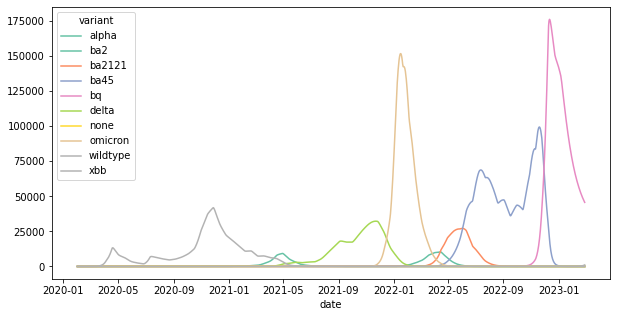

In [7]:
infected_by_variant.plot(figsize=(10, 5), cmap='Set2')

<AxesSubplot:xlabel='date'>

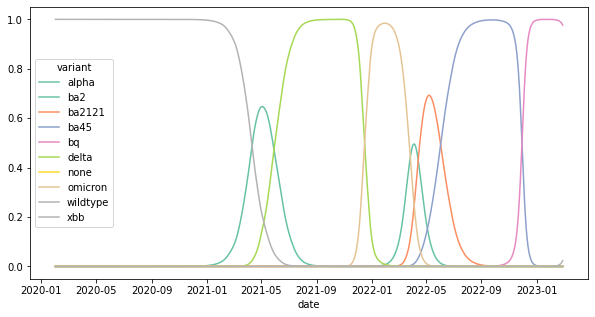

In [8]:
infected_by_variant.div(infected_by_variant.sum(axis=1), axis=0).plot(figsize=(10, 5), cmap='Set2')

In [9]:
# Saves data from plot above to .csv file - may need to update file path and name depending on preferences
new_infected_by_variant = infected_by_variant.div(infected_by_variant.sum(axis=1), axis=0)
new_df = pd.DataFrame(new_infected_by_variant)
new_df.to_csv('./covid_model/output/norm_variant_prev.csv')

<AxesSubplot:xlabel='Date'>

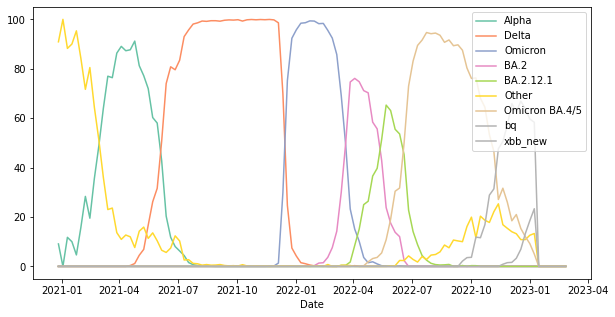

In [10]:
obs_rows = (obs.index.values >= start_date) & (obs.index.values <= end_date)
obs['Omicron BA.4/5'] = obs['BA.4'] + obs['BA.5']
obs['bq'] = obs['BQ.1'] + obs['BQ.1.1']
obs['xbb_new'] = obs['XBB'] + obs['XBB.1.5']
obs = obs.drop(columns=['BA.4', 'BA.5','BQ.1','BQ.1.1','XBB','XBB.1.5']).loc[obs_rows,]
obs.plot(figsize=(10,5), cmap='Set2')

In [11]:
#infected_by_variant.sum(axis=1).plot(figsize=(10, 5))

In [12]:
#model.modeled_vs_observed_hosps().plot(figsize=(10,5), cmap='Set2')

In [13]:
#do_create_report(model, outdir)

### Make figure plot comparing CDPHE data and model variant share for each variant separately

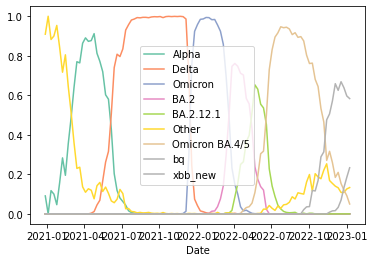

In [14]:
# Clean up obs data under new df (new_obs) to make plotting easier

# Normalize observed data
new_obs = obs.div(obs.sum(axis=1), axis=0)
# Get rid of seperate BA.4 and BA.5 columns
#new_obs = new_obs.drop(columns=['BA.4', 'BA.5'])
# Change column labels to match those of our model column labels
new_obs.plot(cmap='Set2')
new_obs = new_obs.rename(columns={"Alpha":"alpha", "Delta":"delta", "Omicron":"omicron", "BA.2":"ba2",
                                  "BA.2.12.1":"ba2121","Other":"wildtype", "Omicron BA.4/5":"ba45", "bq": "bq", "xbb_new":"xbb"})
# Similarly, make the column order alphabetical like in our modeled dataframe
new_obs = new_obs.reindex(columns=["alpha","ba2","ba2121","ba45","bq","delta","omicron","wildtype","xbb"])
# Create data label column that signifies each entry is observed data - this is useful for when we concat
# this dataset with the modeled dataset
new_obs['data_label'] = ['obs']*len(new_obs['alpha'])
# Make the date into a column instead of the index. This just makes plotting easier later on
new_obs['date'] = new_obs.index

<AxesSubplot:xlabel='Date'>

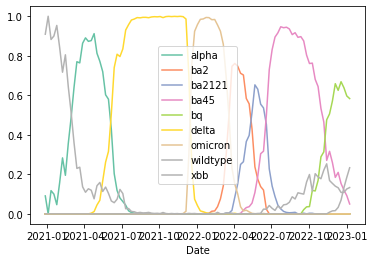

In [15]:
new_obs.plot(cmap='Set2')

<AxesSubplot:xlabel='date'>

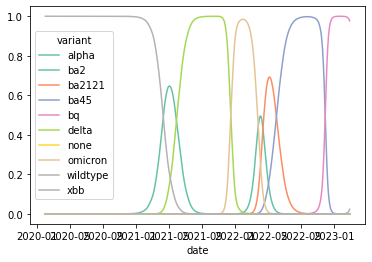

In [16]:
new_df.plot(cmap='Set2')

In [17]:
# Now, we make our new dataframe for modeled variant prevalence (new_df)

# Drop the 'none' column since we have nothing to compare this to in our observed data
new_df = new_df.drop(columns=["none"])
new_df['data_label'] = ['modeled']*len(new_df['alpha'])
new_df['date'] = new_df.index
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1124 entries, 2020-02-01 to 2023-02-28
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   alpha       1124 non-null   float64
 1   ba2         1124 non-null   float64
 2   ba2121      1124 non-null   float64
 3   ba45        1124 non-null   float64
 4   bq          1124 non-null   float64
 5   delta       1124 non-null   float64
 6   omicron     1124 non-null   float64
 7   wildtype    1124 non-null   float64
 8   xbb         1124 non-null   float64
 9   data_label  1124 non-null   object 
 10  date        1124 non-null   object 
dtypes: float64(9), object(2)
memory usage: 137.7+ KB


In [18]:
new_obs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114 entries, 2020-12-27 to 2023-02-26
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   alpha       107 non-null    float64
 1   ba2         107 non-null    float64
 2   ba2121      107 non-null    float64
 3   ba45        107 non-null    float64
 4   bq          107 non-null    float64
 5   delta       107 non-null    float64
 6   omicron     107 non-null    float64
 7   wildtype    107 non-null    float64
 8   xbb         107 non-null    float64
 9   data_label  114 non-null    object 
 10  date        114 non-null    object 
dtypes: float64(9), object(2)
memory usage: 10.7+ KB


In [19]:
# Concatenate our dataframes to make plotting with the 'hue' seaborn feature simple
all_data = pd.concat([new_df, new_obs], ignore_index=True)

In [20]:
# Set seaborn plotting template
sns.set_style('darkgrid')
sns.set_context("paper")

In [21]:
# Set other specifics about plotting like color palette and legend texts
colors = ['peru', 'cadetblue']
sns.set_palette(sns.color_palette(colors))
legend_texts = ['Modeled', 'Observed']

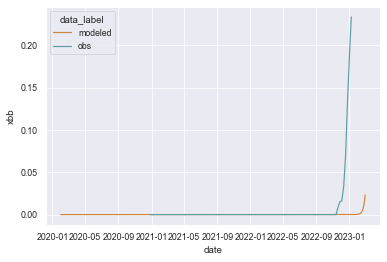

In [24]:
plot = sns.lineplot(data=all_data, x='date', y='xbb', hue="data_label", palette=colors)

In [23]:
# Plot and save figure for each variant comparison
# ***Note: This will not show the plots in the jupyter notebook, but rather output them to you *main* directory
for col in all_data:
    plot = sns.lineplot(data=all_data, x='date', y=col, hue="data_label", palette=colors)
    plot.set(xlabel='Date', ylabel='Variant Prevalence (Normalized)')
    plot.set_title(f'{col} variant share')
    h,l = plot.get_legend_handles_labels()
    l = legend_texts
    plot.legend(h,l, loc=0, borderaxespad=0.,title='Data Source' ,fontsize=10)
    plot.get_figure().savefig(f"{col}_variant_share.png", dpi=300, bbox_inches = "tight")
    plt.clf()

<Figure size 432x288 with 0 Axes>